In [30]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import autogluon.core as ag
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
import torch
import pickle


In [2]:
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0

True
1


In [3]:
df_avg = pd.read_pickle('../Data/ELC_12-14_1D_dropped_avg.pkl')

df_avg_convert = df_avg.copy()
df_avg_convert['id'] = 1
df_avg_convert = df_avg_convert.rename(columns = {"y": "target"})
df_avg_convert = TimeSeriesDataFrame.from_data_frame(
    df_avg_convert,
    id_column="id",
    timestamp_column="ds"
)

df_avg_convert.head()

target
item_id timestamp               
1       2012-01-01  38313.751557
        2012-01-02  57225.098775
        2012-01-03  57294.353754
        2012-01-04  57503.687632
        2012-01-05  57662.515150

In [9]:
training_x = df_avg_convert.iloc[:int(len(df_avg_convert)*0.9)]
val_x = df_avg_convert.iloc[int(len(df_avg_convert)*0.8):int(len(df_avg_convert)*0.9)]
testing_x = df_avg_convert.iloc[int(len(df_avg_convert)*0.9):]
print("training: ", training_x.shape)
print("validation: ", val_x.shape)
print("testing: ", testing_x.shape)

training:  (986, 1)
validation:  (110, 1)
testing:  (110, 1)


In [13]:
testing_x.head()

target
item_id timestamp               
1       2014-09-13  72292.267023
        2014-09-14  70202.463486
        2014-09-15  70181.564710
        2014-09-16  68914.481103
        2014-09-17  67629.143250

### TFT

In [72]:
predictor_TFT = TimeSeriesPredictor(prediction_length = 110, eval_metric="MAPE", presets="high_quality")

predictor_TFT.fit(
    training_x,
    hyperparameters={
        "TemporalFusionTransformer":{
            "hidden_dim": ag.space.Categorical(16, 32, 64, 128, 256),
            "variable_dim ": ag.space.Categorical(16, 32, 64, 128, 256),
            "dropout_rate": ag.space.Categorical(0.1, 0.3),
            "num_heads": ag.space.Categorical(4, 8)}
    },
    ag_args_fit={'num_gpus': 1},
    hyperparameter_tune_kwargs="auto",
    enable_ensemble=False,
)

No path specified. Models will be saved in: "AutogluonModels\ag-20230502_212826\"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'ag_args_fit': {'num_gpus': 1},
 'enable_ensemble': False,
 'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': 'auto',
 'hyperparameters': {'TemporalFusionTransformer': {'dropout_rate': Categorical[0.1, 0.3],
                                                   'hidden_dim': Categorical[16, 32, 64, 128, 256],
                                                   'num_heads': Categorical[4, 8],
                                                   'variable_dim ': Categorical[16, 32, 64, 128, 256]}},
 'prediction_length': 110,
 'random_seed': None,
 'target': 'target',
 'time_limit': None}
Provided training data set with 986 rows, 1 items (item = single time series). Average time series length is 986.0.
Training artifacts will be saved to: C:\Users\Alex\OneDrive - University of Rochester\Desktop

In [73]:
predictions_TFT = predictor_TFT.predict(training_x)
best_mape = mean_absolute_percentage_error(testing_x['target'], predictions_TFT['mean'])
print(best_mape)

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: TemporalFusionTransformer\T9


0.09774981018329952


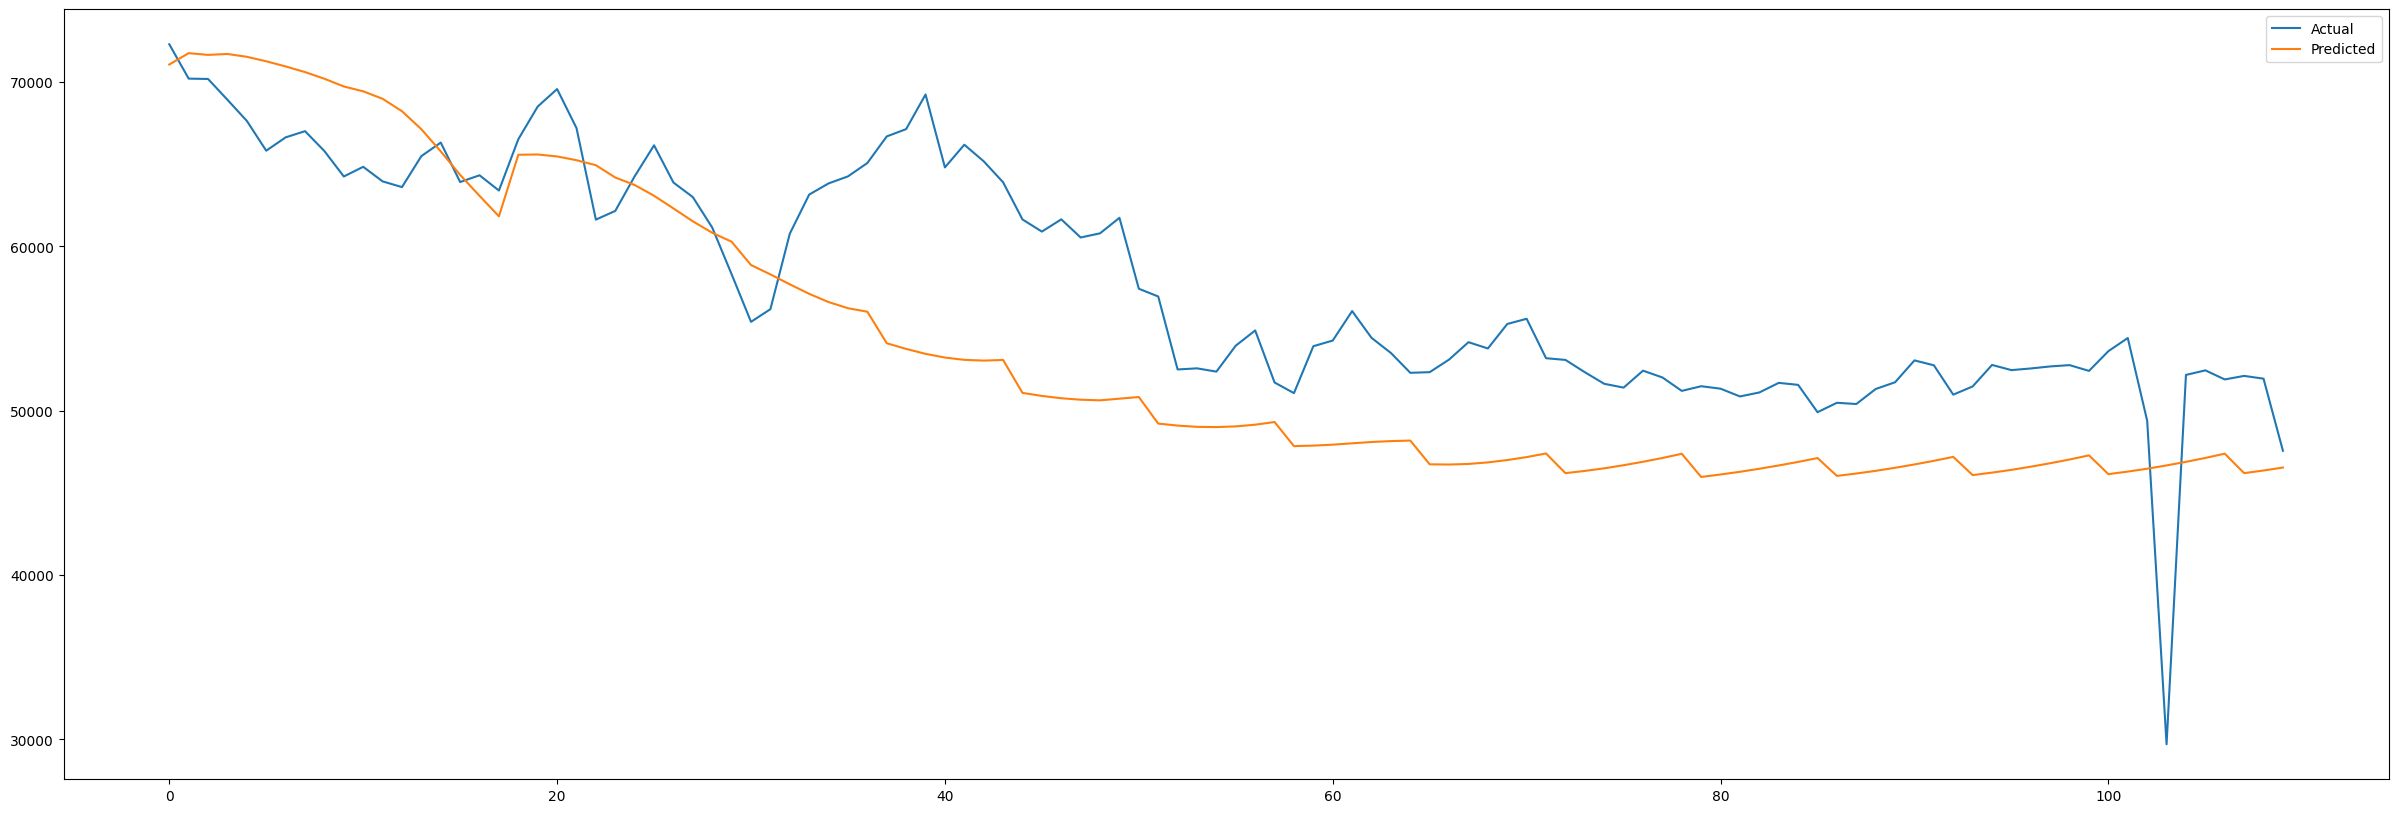

In [74]:
plt.figure(figsize=(30,10))
plt.plot(testing_x['target'].values, label='Actual')
plt.plot(predictions_TFT['mean'].values,label='Predicted')
plt.legend()
plt.show()

MAPE test1:  0.04652010337897179
MAPE test1:  0.1340772369540707
MAPE test1:  0.11126750354646889


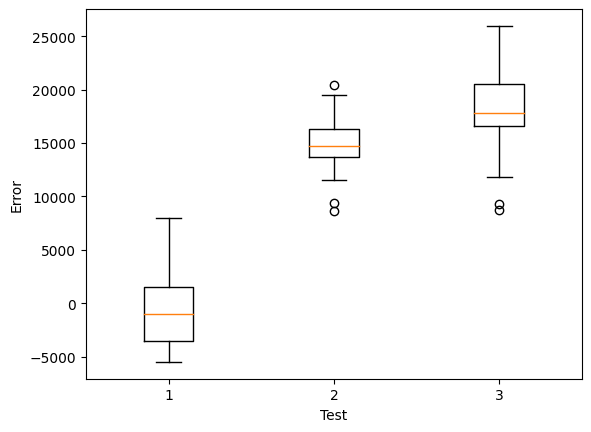

In [75]:
test1 = testing_x.iloc[:int(len(testing_x)/3)].reset_index(drop=True)
test2 = testing_x.iloc[int(len(testing_x)/3):int(len(testing_x)*2/3)].reset_index(drop=True)
test3 = testing_x.iloc[int(len(testing_x)*2/3):].reset_index(drop=True)

predictions_TFT_1 = predictions_TFT.iloc[:int(len(predictions_TFT)/3)].reset_index(drop=True)
predictions_TFT_2 = predictions_TFT.iloc[int(len(predictions_TFT)/3):int(len(predictions_TFT)*2/3)].reset_index(drop=True)
predictions_TFT_3 = predictions_TFT.iloc[int(len(predictions_TFT)*2/3):].reset_index(drop=True)

err = pd.DataFrame(columns=['test1','test2','test3'])
mape_test = []

err['test1'] = test1['target'] - predictions_TFT_1['mean']
mape_test.append(mean_absolute_percentage_error(test1['target'], predictions_TFT_1['mean']))
print("MAPE test1: ", mean_absolute_percentage_error(test1['target'], predictions_TFT_1['mean']))

err['test2'] = test1['target'] - predictions_TFT_2['mean']
mape_test.append(mean_absolute_percentage_error(test2['target'], predictions_TFT_2['mean']))
print("MAPE test1: ", mean_absolute_percentage_error(test2['target'], predictions_TFT_2['mean']))

err['test3'] = test1['target'] - predictions_TFT_3['mean']
mape_test.append(mean_absolute_percentage_error(test3['target'], predictions_TFT_3['mean']))
print("MAPE test1: ", mean_absolute_percentage_error(test3['target'], predictions_TFT_3['mean']))

plt.boxplot(err)
plt.xlabel('Test')
plt.ylabel('Error')
plt.show()

